## Своевременность доставок ВИП

In [1]:
import os
import pandas as pd
import numpy as np
import datetime

from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from matplotlib.ticker import FuncFormatter
import plotly.express as px


pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
warnings.filterwarnings("ignore")

## Вспомогательные

In [2]:
# Склады для удаления (виртуальные/неактуальные)
delete_warhouse = [40813, 40811, 40812, 40814, 40815, 187, 835, 581, 84,586,87,89,
                   83,86,1208,1207,1205,1201,1203,1206,1202,1204,111,12120,12170,12000,12140,12180,12150,12130]
# клиенты для удаления (не являются вип но доставка согласована и т.д.)
delete_clients = [690006252,690012336,740000847,690000889,690008543,690012743,690000654,690009355,740000188,
                  740000723,690012337,740001028,740000137,60226,740000514,740000787,690023569,740001043,126909,
                  690012335,690020932,740000148,690000654,30008979,400000041,740000495]

# сегодня
now_row = datetime.datetime.now()
now = now_row.strftime("%Y-%m-%d %H-%M-%S")
# сейвер
archive_path = f"C:\\Users\\rassadin_mi\\Desktop\\автоматизация отчёт ЦО\\Своевременность ВИП\\Архив\\{now} своевременность ВИП.xlsx"



## Исходники

In [3]:
# Основной файл
vip_report = PR_compliants_lines_lc = pd.read_excel(
    "C:\\Users\\rassadin_mi\\Desktop\\автоматизация отчёт ЦО\\Своевременность ВИП\\VIP.xlsx")
# Списки  складов и офисов
VPR_office_number = pd.read_excel(
    "C:\\Users\\rassadin_mi\\Desktop\\автоматизация отчёт ЦО\\отчёт по ЦО\\ВПР\\ВПР склад-офис.xlsx")
# Создаю список для удобства
key_office_number = dict(zip(VPR_office_number['Склад'], VPR_office_number['ЛЦ']))

## Предобработка


In [4]:
# Перевод дат в адекватные форматы
vip_report['Заявка датавремя с'] = pd.to_datetime(
    vip_report['Заявка датавремя с'], format='%d.%m.%Y %H%M', errors='coerce').fillna(pd.to_datetime(
    vip_report['Заявка датавремя с'], format='%Y/%m/%d %H%M', errors='coerce'))
vip_report['Заявка датавремя по'] = pd.to_datetime(
    vip_report['Заявка датавремя по'], format='%d.%m.%Y %H%M', errors='coerce').fillna(pd.to_datetime(
    vip_report['Заявка датавремя по'], format='%Y/%m/%d %H%M', errors='coerce'))
vip_report['МЛ датавремя факт'] = pd.to_datetime(vip_report['МЛ датавремя факт'], format='%Y-%m-%d %H:%M:%S',
                                                 errors='coerce')

In [5]:
vip_report.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12393 entries, 0 to 12392
Data columns (total 20 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   ТрСклад                               12393 non-null  int64         
 1   Территория                            12276 non-null  object        
 2   Дата ТД                               11953 non-null  datetime64[ns]
 3   номер заяв                            12393 non-null  object        
 4   Номер ТД                              11953 non-null  object        
 5   СкПол код                             12393 non-null  int64         
 6   Клиент название                       12393 non-null  object        
 7   VIP                                   12393 non-null  object        
 8   Менеджер                              9854 non-null   object        
 9   Клиент ЦКГ                            11787 non-null  object        
 10

## Обработка

In [6]:
# функция для поиска символа "v" в номере заявки (её наличие напрямую говорит нм о вип доставке)
def get_vip(row):
    if "v" in row["номер заяв"]:
        return "VIP"
    else:
        return "not VIP"
vip_report["VIP"] = vip_report.apply(get_vip, axis=1)

In [7]:
# Создаю столбец с принадлежностью склдаов к логисчитеским центрам
def get_lc(row):
    if row['СкПол код'] in key_office_number :
        return key_office_number [row['СкПол код']]

vip_report['ЛЦ'] = vip_report.apply(get_lc, axis=1)

In [8]:
# Удаление всего что пустое при випе == нет
index_to_drop = vip_report[(vip_report['ЛЦ'].isnull()) & (vip_report['VIP'] == 'not VIP')].index
vip_report_no_null = vip_report.drop(index_to_drop)

In [9]:
# Удалаяю клиентов и склады вне учёта
vip_report_clear = vip_report_no_null.drop(vip_report_no_null[vip_report_no_null['Клиент код']
                                                              .isin(delete_clients)].index)
vip_report_clear = vip_report_clear.drop(vip_report_clear[vip_report_clear['СкПол код']
                                                              .isin(delete_warhouse)].index)

In [10]:
# заполняю пропуски шаблонной датой '1999-01-01' для удобства
# функция смотрит попадание фактического времени приезда водителя по чеклисту в интервал указанный клиентом
# и возвращает ранее\опоздание\во время или нет данных (если дата равна шаблонной)
vip_report_clear["МЛ датавремя факт"] = vip_report_clear["МЛ датавремя факт"].fillna(pd.to_datetime('1999-01-01'))
def get_late(row):
    time_part = row["МЛ датавремя факт"].time()
    if time_part == datetime.time(0, 0, 0):
        return  "нет данных"
    elif row["МЛ датавремя факт"].date == pd.to_datetime('1999-01-01'):
        return "нет данных"
    elif row["МЛ датавремя факт"] < row["Заявка датавремя с"]:
        return "ранее"
    elif row["МЛ датавремя факт"] >= row["Заявка датавремя с"] and row["МЛ датавремя факт"] <= row["Заявка датавремя по"]:
        return "во время"
    elif row["МЛ датавремя факт"] > row["Заявка датавремя по"]:
        return "опоздание"

In [11]:
vip_report_clear["Опоздание"] = vip_report_clear.apply(get_late, axis=1)

In [12]:
# считаю время опоздания в минутах
def time_late(row):
    if row["Опоздание"] == "опоздание":
        timedelta =row["МЛ датавремя факт"] - row["Заявка датавремя по"]
        minutes_diff = timedelta.total_seconds() / 60
        minutes_diff = round(minutes_diff)
        return minutes_diff
    else:
        return row["Опоздание"]

In [13]:
get_late_list = vip_report_clear['Опоздание'].unique()

In [14]:
vip_report_clear["время опоздания"] = vip_report_clear.apply(time_late, axis=1)

In [15]:
# Устанавливаю критерий (категоризация по величине опоздания в минутах)
def criteria(row):
    if row['время опоздания'] in get_late_list:
        return row['время опоздания']
    elif row["время опоздания"] < 30:
        return "до 30 минут"
    elif row["время опоздания"] >= 30 and row[
        "время опоздания"]  < 60:
        return "от 30 минут до 1 часа"
    elif row["время опоздания"] >= 60 and row[
        "время опоздания"]  < 120:
        return "от 1 часа до 2 часов"
    elif row["время опоздания"] >= 120 and row[
        "время опоздания"]  < 1440:
        return "от 2 часов до суток"
    elif row["время опоздания"] >= 1440:
        return "более суток"

In [16]:
vip_report_clear["критерий"] = vip_report_clear.apply(criteria, axis=1)

In [17]:
# В  Новосибирске есть междугородние маршруты, принято их не учитывать

delete = ["НХаб","НИрк", "НКрс", "НВлд", "УОмск", "Усур"]
vip_report_clear['Территория'] = vip_report_clear['Территория'].astype(str)
# Фильтрация данных
filtered_data = vip_report_clear[(vip_report_clear['ЛЦ'] == "Новосибирск") &
                                 (vip_report_clear['Территория'].str.contains('|'.join(delete), case=False))]
# Удаление строк, соответствующих условию
vip_report_clear = vip_report_clear.drop(filtered_data.index)

In [18]:
vip_report_clear.head()

,ТрСклад,Территория,Дата ТД,номер заяв,Номер ТД,СкПол код,Клиент название,VIP,Менеджер,Клиент ЦКГ,Клиент код,Клиент класс 72,Менеджер ОП назв,Заявка датавремя с,Заявка датавремя по,МЛ датавремя факт,Опоздание,Попадание в интервал доставки Да/Нет,МЛ номер строки,Комментарий,ЛЦ,время опоздания,критерий
1,7712,уекат00,2023-10-30,5120.уекат00.502/1002986,502/10765,5120,Ботнор Евгений Александрович,not VIP,NaN,0im0,440218212,NaN,NaN,2023-11-02 09:00:00,2023-11-02 10:00:00,2023-10-06,нет данных,NaN,1,NaN,Екатеринбург,нет данных,нет данных
2,7712,Усур00,2023-10-31,1391.Усур00.527/1012627,527/1012609-11,1391,Плотников Михаил,not VIP,NaN,0im1,160135413,NaN,NaN,2023-11-02 08:00:00,2023-11-02 09:00:00,2023-10-16,нет данных,NaN,1,NaN,Екатеринбург,нет данных,нет данных
4,7712,Усур00,2023-10-30,1391.Усур00.527/1012628,527/1012603,1391,Ашпин Денис Алексеевич,not VIP,NaN,0ic5,36174209,NaN,NaN,2023-11-02 08:00:00,2023-11-02 17:00:00,2023-10-18,нет данных,NaN,1,NaN,Екатеринбург,нет данных,нет данных
5,7712,Усур00,2023-10-24,139110.Усур00.530/1059567,530/1059517,139110,Хакимов Хакимжон,not VIP,NaN,0ic3,330284859,NaN,NaN,2023-11-02 15:00:00,2023-11-02 16:00:00,2023-10-19,нет данных,NaN,1,NaN,Екатеринбург,нет данных,нет данных
6,7712,уекат00,2023-10-23,5120.уекат00.502/1002987,502/40415240,5120,Погребной Вячеслав,not VIP,NaN,0ic3,36156171,NaN,NaN,2023-11-02 09:00:00,2023-11-02 10:00:00,2023-10-20,нет данных,NaN,1,NaN,Екатеринбург,нет данных,нет данных


In [19]:
# райтер
writer = pd.ExcelWriter(archive_path)
# Запись
vip_report_clear.to_excel(writer, sheet_name=f'ВИП', index=False)
# Сохранение
writer.save()

## Выводы и графики

### Общий анализ по доставкам

In [20]:
# Оставляю только ВИП - этот отчёт по ним
only_vip = vip_report_clear.query("'VIP' == VIP")


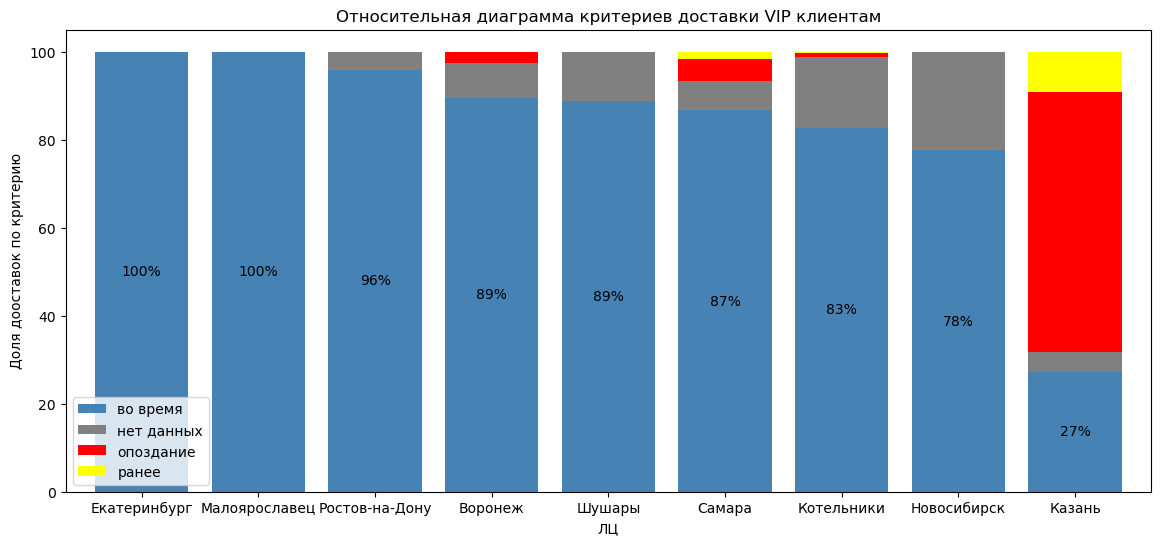

In [21]:
only_vip_pivot = pd.pivot_table(only_vip, index='ЛЦ', columns='Опоздание', aggfunc='size', fill_value=0).reset_index()

normalized_pivot = only_vip_pivot.copy()
normalized_pivot.iloc[:, 1:] = normalized_pivot.iloc[:, 1:].div(normalized_pivot.iloc[:, 1:].sum(axis=1), axis=0) * 100
normalized_pivot = normalized_pivot.sort_values("во время", ascending=False)



ax = normalized_pivot.set_index('ЛЦ').plot(kind='bar', stacked= True ,
                                      color=['steelblue', 'grey', 'red', 'yellow'], figsize=(14, 6), width=0.8);
ax.set_title('Относительная диаграмма критериев доставки VIP клиентам')
ax.set_xlabel('ЛЦ')
ax.set_ylabel('Доля дооставок по критерию')
ax.legend(loc='lower left')
plt.xticks (rotation= 0 )
for i, label in enumerate(normalized_pivot['во время']):
    ax.annotate(f"{label:.0f}%", (i, label/2), ha='center', va='center');

In [22]:
round(normalized_pivot, 1)

Опоздание,ЛЦ,во время,нет данных,опоздание,ранее
1,Екатеринбург,100.0,0.0,0.0,0.0
4,Малоярославец,100.0,0.0,0.0,0.0
6,Ростов-на-Дону,95.8,4.2,0.0,0.0
0,Воронеж,89.5,7.9,2.6,0.0
8,Шушары,88.8,11.2,0.0,0.0
7,Самара,86.7,6.7,5.0,1.7
3,Котельники,82.7,16.0,0.8,0.4
5,Новосибирск,77.6,22.4,0.0,0.0
2,Казань,27.3,4.5,59.1,9.1


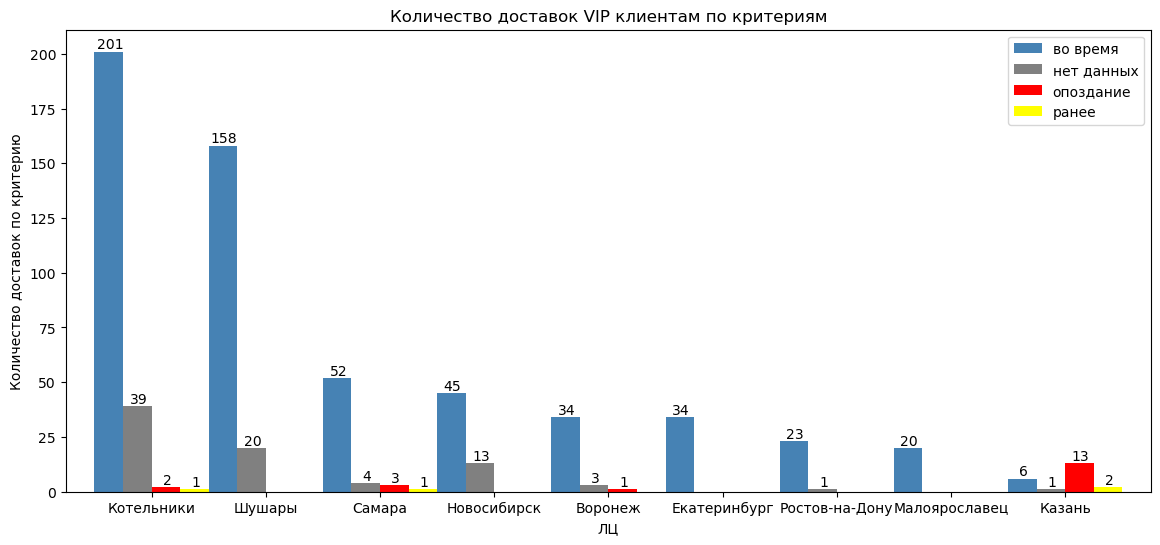

In [87]:
only_vip_pivot =only_vip_pivot.sort_values('во время', ascending= False)
ax = only_vip_pivot.set_index('ЛЦ').plot(kind='bar',
                                      color=['steelblue', 'grey', 'red', 'yellow'], figsize=(14, 6), width=1.0);
ax.set_title('Количество доставок VIP клиентам по критериям')
ax.set_xlabel('ЛЦ')
ax.set_ylabel('Количество доставок по критерию')
ax.legend(loc='upper right')
plt.xticks (rotation= 0 )
labels = ['во время', 'нет данных', 'опоздание', 'ранее']
for i, col in enumerate(only_vip_pivot.columns[1:]):
    for j, label in enumerate(only_vip_pivot[col]):
        if label != 0:  # Проверка на значение, отличное от 0
            ax.annotate(f"{label}", (j + i * 0.25, label), ha='center', va='bottom', xytext=(-30, 0), textcoords='offset points')

### Анализ опозданий

In [24]:
only_vip_late = only_vip[only_vip['Опоздание'] == 'опоздание']
only_vip_late = pd.pivot_table(only_vip_late, index='ЛЦ', columns='критерий',
                               aggfunc='size', fill_value=0).reset_index()
right_order = ['ЛЦ', 'до 30 минут', 'от 30 минут до 1 часа', 'от 1 часа до 2 часов', 'от 2 часов до суток', 'более суток']
only_vip_late = only_vip_late.reindex(columns=right_order)
only_vip_late

критерий,ЛЦ,до 30 минут,от 30 минут до 1 часа,от 1 часа до 2 часов,от 2 часов до суток,более суток
0,Воронеж,0,1,0,0,0
1,Казань,2,2,0,8,1
2,Котельники,0,0,0,2,0
3,Самара,0,0,3,0,0


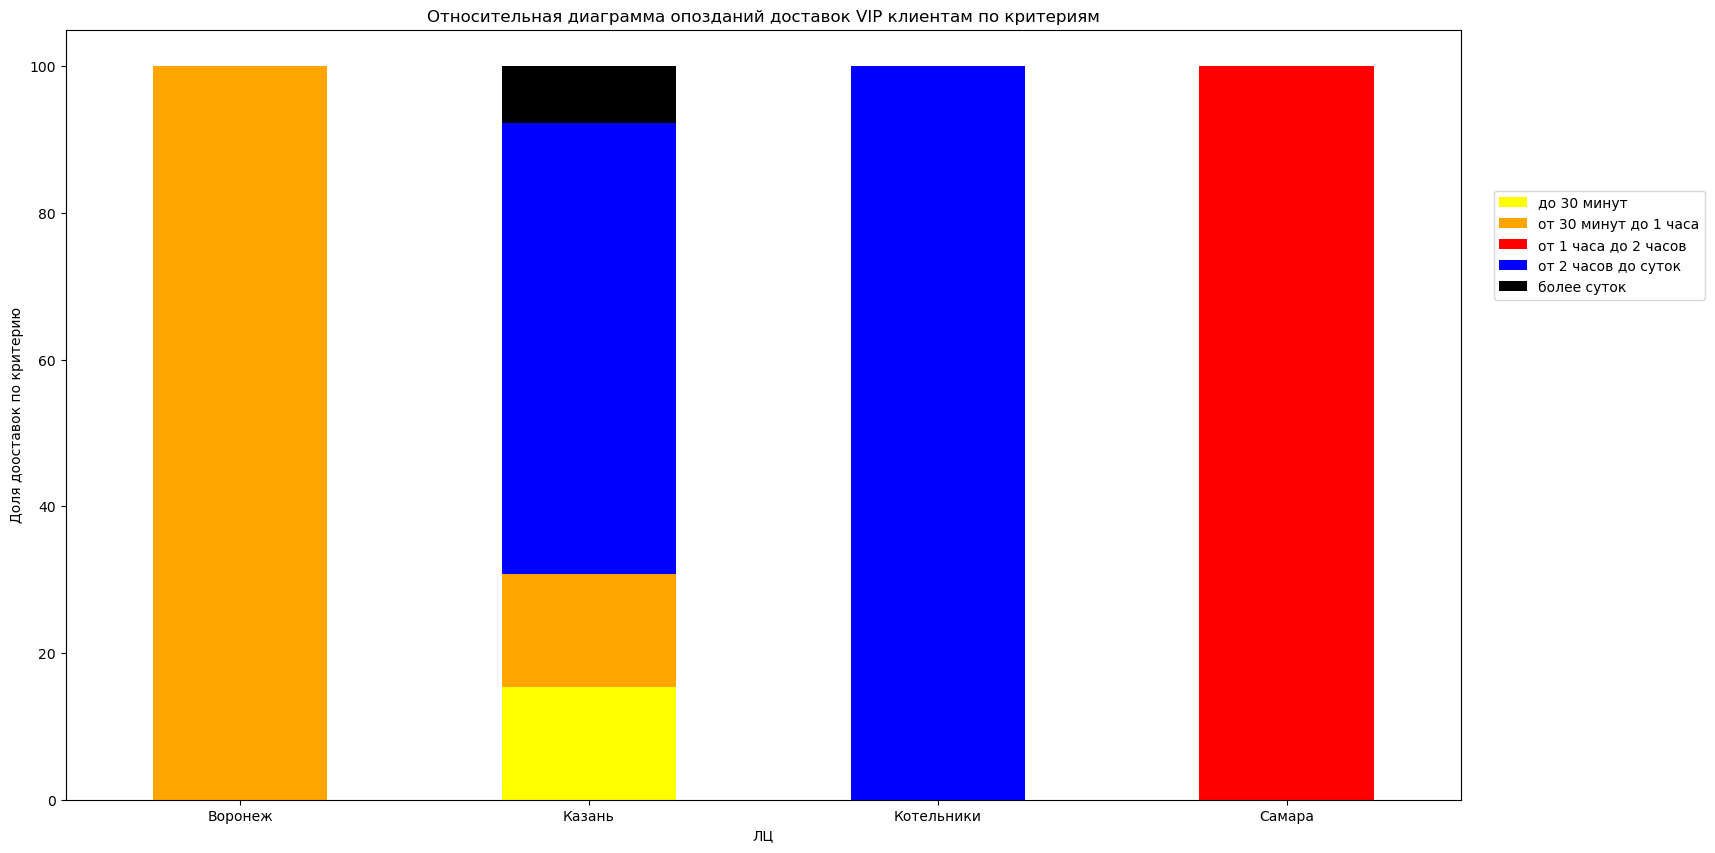

In [25]:
normalized_pivot_late = only_vip_late.copy()
normalized_pivot_late.iloc[:, 1:] = normalized_pivot_late.iloc[:, 1:].div(
    normalized_pivot_late.iloc[:, 1:].sum(axis=1), axis=0) * 100

color_map = {'от 2 часов до суток': 'blue', 'от 1 часа до 2 часов': 'red',
             'от 30 минут до 1 часа': 'orange', 'более суток': 'black', 'до 30 минут': 'yellow'}


ax = normalized_pivot_late.set_index('ЛЦ').plot(kind='bar', stacked= True ,
                                      color=color_map, figsize=(18, 10));
ax.set_title('Относительная диаграмма опозданий доставок VIP клиентам по критериям')
ax.set_xlabel('ЛЦ')
ax.set_ylabel('Доля дооставок по критерию')
ax.legend(loc='upper right', bbox_to_anchor=(1.18, 0.8))
plt.xticks (rotation= 0 );


In [86]:
# Таблица опозданий
only_vip_late

критерий,ЛЦ,до 30 минут,от 30 минут до 1 часа,от 1 часа до 2 часов,от 2 часов до суток,более суток
0,Воронеж,0,1,0,0,0
1,Казань,2,2,0,8,1
2,Котельники,0,0,0,2,0
3,Самара,0,0,3,0,0


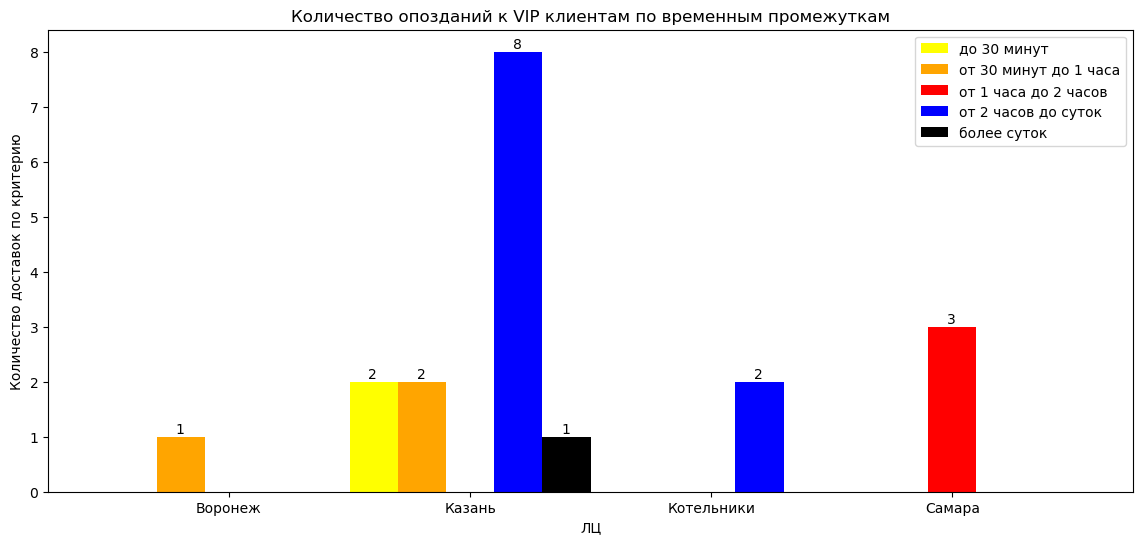

In [89]:

ax = only_vip_late.set_index('ЛЦ').plot(kind='bar',
                                      color=color_map, figsize=(14, 6), width=1.0);
ax.set_title('Количество опозданий к VIP клиентам по временным промежуткам')
ax.set_xlabel('ЛЦ')
ax.set_ylabel('Количество доставок по критерию')
ax.legend(loc='upper right')
plt.xticks (rotation= 0 )
labels = ['до 30 минут', 'от 30 минут до 1 часа', 'от 1 часа до 2 часов', 'от 2 часов до суток', 'более суток']
for i, col in enumerate(only_vip_late.columns[1:]):
    for j, label in enumerate(only_vip_late[col]):
        if label != 0:  # Проверка на значение, отличное от 0
            ax.annotate(f"{label}", (j + i * 0.2, label), ha='center', va='bottom', xytext=(-70, 0), textcoords='offset points')

### Анализ очередности доставок

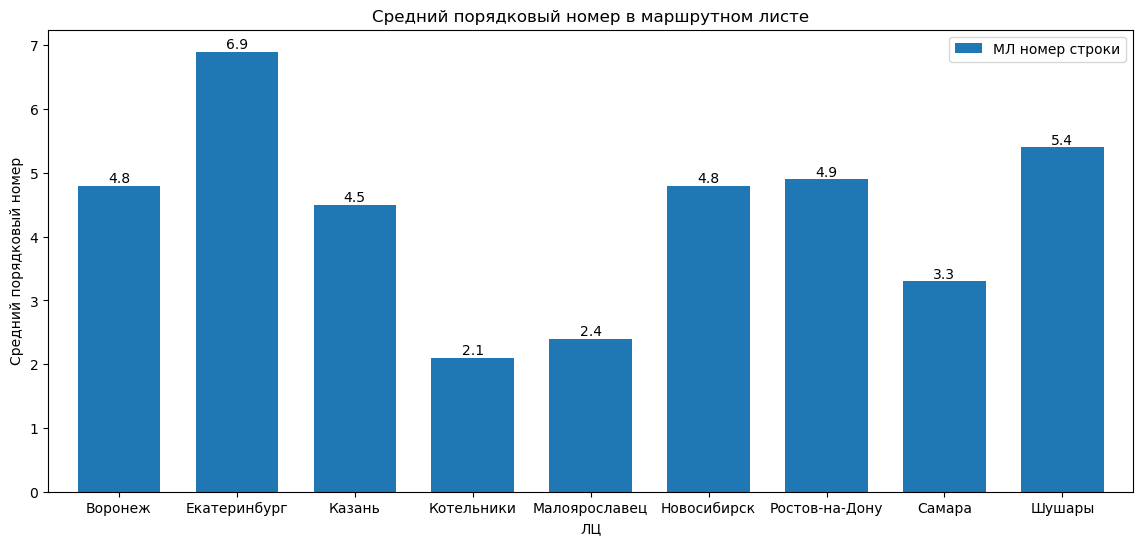

In [28]:
only_vip_priority = round(only_vip.groupby('ЛЦ')['МЛ номер строки'].mean().reset_index(), 1)
ax = only_vip_priority.set_index('ЛЦ').plot(kind='bar', figsize=(14, 6), width=0.7);
ax.set_title('Средний порядковый номер в маршрутном листе')
ax.set_xlabel('ЛЦ')
ax.set_ylabel('Средний порядковый номер')
plt.xticks (rotation=0);
for i, value in enumerate(only_vip_priority['МЛ номер строки']):
    ax.annotate(value, xy=(i, value), ha='center', va='bottom')

plt.show()


In [84]:
only_vip_heatmap = only_vip.pivot_table(only_vip, index='ЛЦ',
                                        columns='МЛ номер строки',aggfunc='size', fill_value=0)
normalized_only_vip_heatmap = only_vip_heatmap.copy()
normalized_only_vip_heatmap.iloc[:, 1:] = normalized_only_vip_heatmap.iloc[:, 1:].div(
    normalized_only_vip_heatmap.iloc[:, 1:].sum(axis=1), axis=0) * 100

normalized_only_vip_heatmap = round(normalized_only_vip_heatmap, 1)

normalized_only_vip_heatmap = normalized_only_vip_heatmap.drop(columns=normalized_only_vip_heatmap.columns[0])


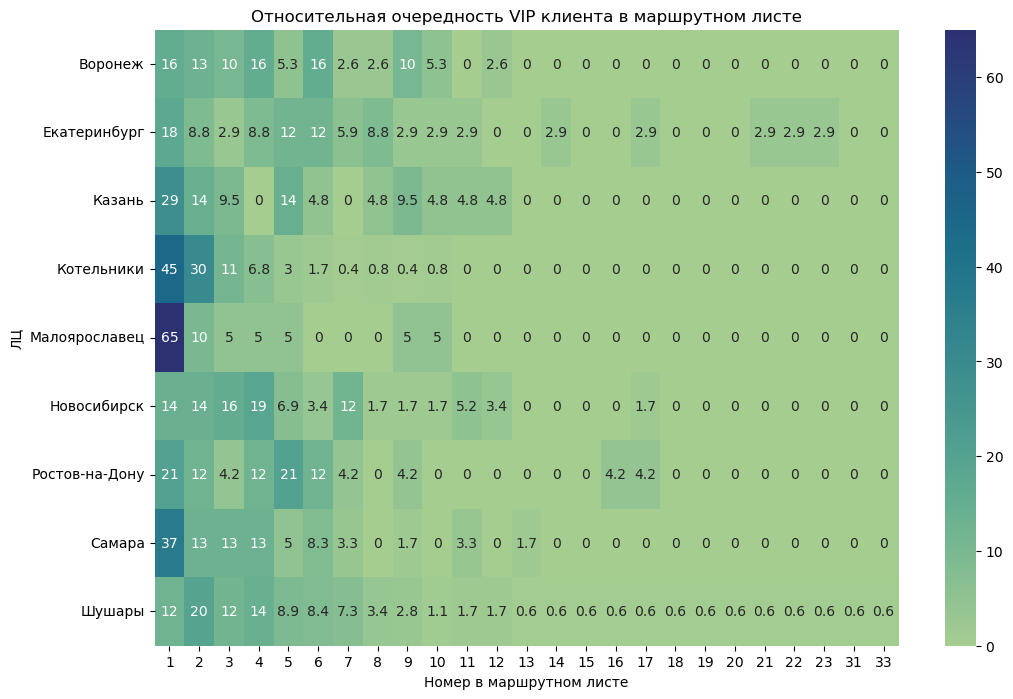

In [83]:
# В этом хитмапе % от сумме значений по строке, то есть количество значения номера в МЛ от общем массы
# Пример - Малоярославец молодцы, в 65% случаев вип клиент в маршрутном листе на 1 строчке
plt.figure(figsize=(12, 8))
sns.heatmap(normalized_only_vip_heatmap, annot=True, cmap="crest")
plt.title('Относительная очередность VIP клиента в маршрутном листе')
plt.xlabel('Номер в маршрутном листе')
plt.ylabel('ЛЦ')
plt.show()